<a href="https://colab.research.google.com/github/alexis24694/proyecto-ml-2020-1/blob/master/proyecto_ml_2020_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto del Curso Aprendizaje Automatico
# Mice Protein Expression Data Set - Grupo D

In [116]:
#Importando las librerias necesarias para la experimentacion
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [ ]:
# Descargar el dataset de un archivo subido al drive mediante su ID
!wget -O Data_Cortex_Nuclear.csv "https://drive.google.com/uc?id=1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05&export=download"

--2020-07-05 23:09:50--  https://drive.google.com/uc?id=1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05&export=download
Resolving drive.google.com (drive.google.com)... 64.233.189.138, 64.233.189.101, 64.233.189.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7k0595depkjd2spqf7pdcshsblec49sp/1593990525000/07257263427831096354/*/1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05?e=download [following]
--2020-07-05 23:09:51--  https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7k0595depkjd2spqf7pdcshsblec49sp/1593990525000/07257263427831096354/*/1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05?e=download
Resolving doc-0k-5k-docs.googleusercontent.com (doc-0k-5k-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Connecting to doc-0k-5k-docs.googleusercontent.com (doc-0k

In [47]:
#Cargando el archivo a un dataframe
data = pd.read_csv('Data_Cortex_Nuclear.csv')

In [66]:
data.shape

(1080, 82)

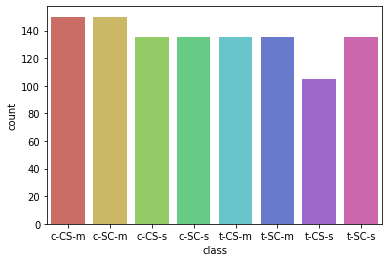

In [93]:
#Visualizando la distribucion de la variable objetivo
sns.countplot(x="class",data=data,palette="hls")
plt.show()

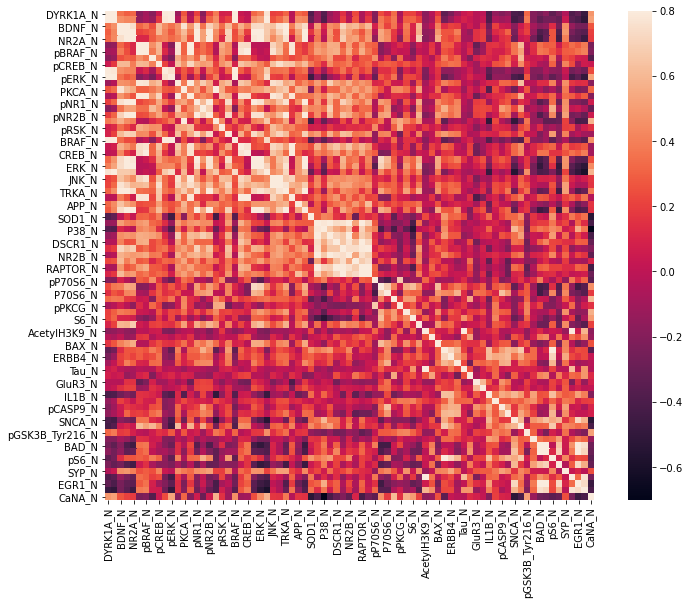

In [94]:
#Visualizando la matriz de correlacion de los datos
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

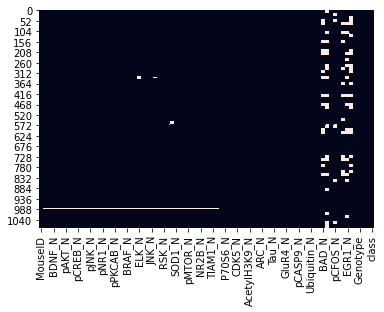

In [9]:
#Visualizando un mapa de calor de los datos nulos
sns.heatmap(data.isnull(), cbar=False)

# Preprocesamiento de datos

In [101]:
#Calculando el porcentaje de valores nulos
null_percentages = data.isnull().sum(axis=0) / data.shape[0]

#Considerando un umbral de 20%
threshold = 0.2

#Se tienen 2 columnas que superan el umbral de valores nulos
null_percentages[null_percentages > threshold]

#Eliminando las columnas cuyo umbral supera el 20%
data = data.loc[:, data.isnull().sum() < 0.2*data.shape[0]]

#Inputando la media de los valores de las mediciones
data = data.fillna(data.mean())


# Clasificacion

In [102]:
#Separando las caracteristicas del target
X = data.loc[:, 'DYRK1A_N':'CaNA_N']
y = data['class']

In [106]:
#Separando el conjunto de entrenamiento y prueba (80% entrenamiento - 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Entrenamiento

In [107]:

model = RandomForestClassifier()
model.fit(X_train, y_train);


In [115]:
#Definiendo los hiperparametros a opmitizar
max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

parameter_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}


rfc = RandomForestClassifier(oob_score = True)
rfc_grid = GridSearchCV(estimator = rfc,
                        scoring = 'f1_micro',   # Se definio en el experimento medir utilizando la metrica f1
                        param_grid = parameter_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )

#Entrenando a un modelo Random Forest
#Encontrando los mejores hiperparametros con GridSearchCV
rfc_grid.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                                 

In [123]:
rfc_prediction = rfc_grid.predict(X_test)
rfc_f1_score = metrics.f1_score(y_test, rfc_prediction, average='micro') 
print('Valor de la metrica f1 para el conjunto de prueba:', rfc_f1_score)

Valor de la metrica f1: 0.9907407407407407
